<a href="https://colab.research.google.com/github/skumarudel/DSPS_SKumar/blob/master/HW10/AutoEncoders_OnFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
cd /content/gdrive/Shareddrives/DSPS2021

/content/gdrive/Shareddrives/DSPS2021


In [12]:
!ls

10802534_761689917241346_821292660_n.jpg  galaxies.npy
ak0.png					  higgsb
ak1.png					  images_test_rev1.zip
ak2.png					  images_training_rev1
ak3.png					  images_training_rev1.zip
ak4.png					  kaggleTitanic
all_ones_benchmark.zip			  nyzipcodes
all_zeros_benchmark.zip			  training_solutions_rev1.csv
central_pixel_benchmark.zip		  training_solutions_rev1.zip
data					  uo_img.jpg


# Read the data

In [13]:
flist = glob.glob("data/faces95/*jpg")
N = len(flist)
print(N)

1440


((70, 70, 1), 540)

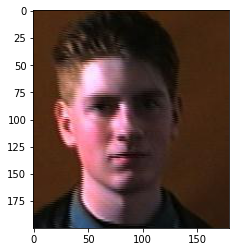

In [14]:
im = Image.open(flist[40])
np_im = np.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

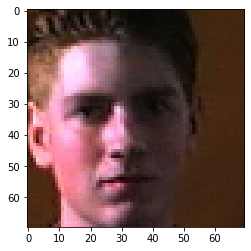

In [15]:
pl.imshow(np_im[25:165:2,25:165:2])

In [8]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i,f in enumerate(flist):
  if not i%50: print(i)
  im = Image.open(flist[i])
  np_im = np.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = np.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy


0


KeyboardInterrupt: ignored

In [ ]:
# I just saved it to my own directroy
np.save("/content/gdrive/MyDrive/machine_learning_course/autoencoders/faces_saved.npy", imgs)

In [16]:
imgs = np.load("data/faces.npy")
imgs.shape

(1440, 70, 70, 1)

# Change Resolution of data for fast processing

In [17]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [18]:
imgs.shape

(1440, 70, 70, 1)

In [19]:
# lower the resolution
# example: take one every N pixels
imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
#imgs_lr = imgs.reshape(...).mean(...).mean(...)
imgs_lr.shape

(1440, 35, 35, 1)

In [20]:
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1225, 4900)

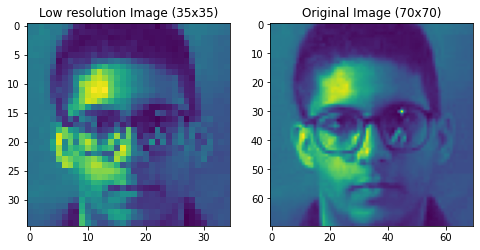

In [21]:
fig,axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(imgs_lr[55].reshape(35,35))
axes[0].set_title("Low resolution Image (35x35)")
axes[1].imshow(imgs[55].reshape(70,70))
axes[1].set_title("Original Image (70x70)");

## Creating Training and Test data sets

In [39]:
X_tr,  X_te, y_tr, y_te = train_test_split(imgs, imgs, test_size=0.30, random_state=69)

In [40]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1008, 70, 70, 1), (432, 70, 70, 1), (1008, 70, 70, 1), (432, 70, 70, 1))

In [41]:
#each image needs to be unravel into a flat array
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [42]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1008, 4900), (432, 4900), (1008, 4900), (432, 4900))

In [43]:
xshape = X_tr.shape[1]
ndim = X_tr.shape[1]

In [56]:
model_face = Sequential()
## encoder
model_face.add(Dense(1024, activation='relu', input_dim=xshape))
model_face.add(Dense(256, activation='relu', input_dim=xshape))
# input layer and the output size
model_face.add(Dense(128, activation='relu', input_dim=xshape))
#compression layer
model_face.add(Dense(64, activation='relu'))
## deencoder
#decompression layer, same size as in the encoder
#model_face.add(Dense(128, activation='relu'))
#output layer, same size as input
model_face.add(Dense(256, activation='relu'))
model_face.add(Dense(1024, activation='relu'))
#output layer, same size as input
model_face.add(Dense(ndim, activation='sigmoid'))

In [57]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model_face.compile(optimizer=opt, loss="binary_crossentropy")
print(model_face.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1024)              5018624   
                                                                 
 dense_29 (Dense)            (None, 256)               262400    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 256)               16640     
                                                                 
 dense_33 (Dense)            (None, 1024)              263168    
                                                                 
 dense_34 (Dense)            (None, 4900)             

In [59]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
history_face = model_face.fit(X_tr, y_tr,
                epochs=500,
                batch_size=64,
                shuffle=True,
                validation_data=(X_te, y_te),callbacks=[callback])


Epoch 1/500
16/16 [==============================] - 0s 22ms/step - loss: 0.5444 - val_loss: 0.5416
Epoch 2/500
16/16 [==============================] - 0s 17ms/step - loss: 0.5435 - val_loss: 0.5396
Epoch 3/500
16/16 [==============================] - 0s 19ms/step - loss: 0.5405 - val_loss: 0.5381
Epoch 4/500
16/16 [==============================] - 0s 17ms/step - loss: 0.5390 - val_loss: 0.5367
Epoch 5/500
16/16 [==============================] - 0s 16ms/step - loss: 0.5381 - val_loss: 0.5358
Epoch 6/500
16/16 [==============================] - 0s 15ms/step - loss: 0.5367 - val_loss: 0.5346
Epoch 7/500
16/16 [==============================] - 0s 17ms/step - loss: 0.5359 - val_loss: 0.5340
Epoch 8/500
16/16 [==============================] - 0s 15ms/step - loss: 0.5349 - val_loss: 0.5336
Epoch 9/500
16/16 [==============================] - 0s 17ms/step - loss: 0.5349 - val_loss: 0.5336
Epoch 10/500
16/16 [==============================] - 0s 15ms/step - loss: 0.5348 - val_loss: 0.5338

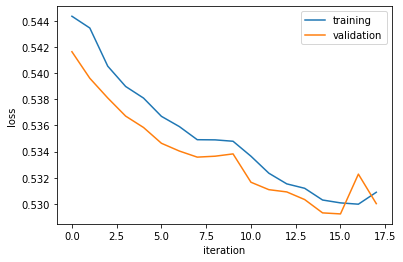

In [60]:
pl.plot(np.array(history_face.history['loss']), label="training")
pl.plot(np.array(history_face.history['val_loss']), label="validation")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.legend();
#pl.yscale('log')
#pl.xscale('log')

In [61]:
output_image = model_face.predict(X_te)

In [62]:
def compareinout(i, outim, testimg, initialshape=(int(np.sqrt(X_tr.shape[1])), int(np.sqrt(X_tr.shape[1])))):
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(121) 
  ax.imshow(testimg[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(122) 
  ax.imshow(outim[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

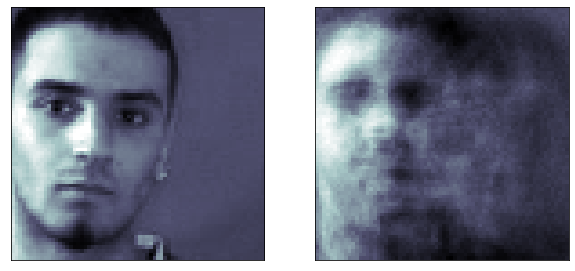

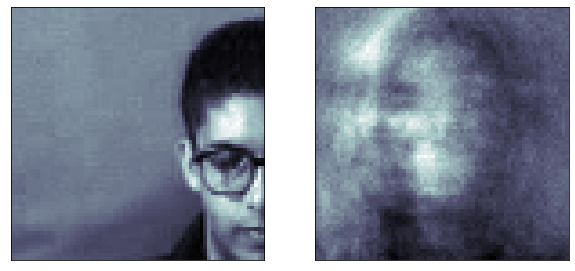

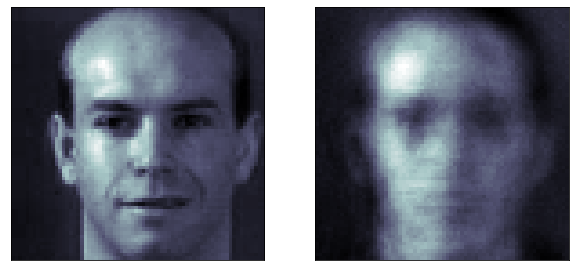

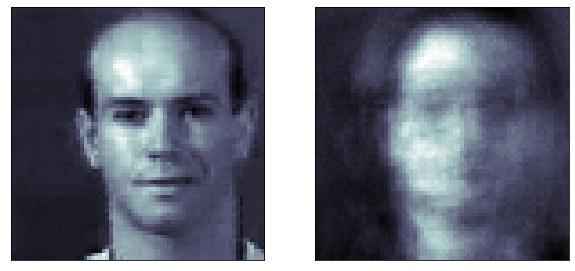

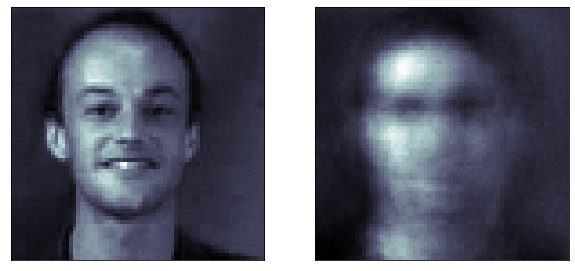

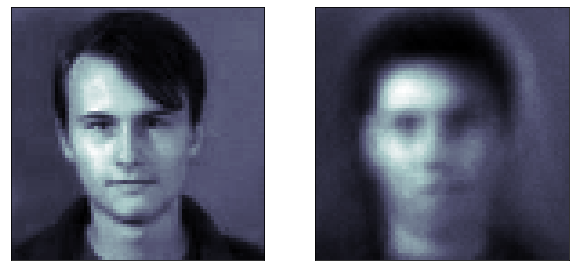

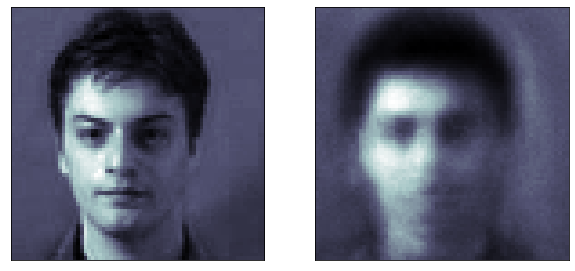

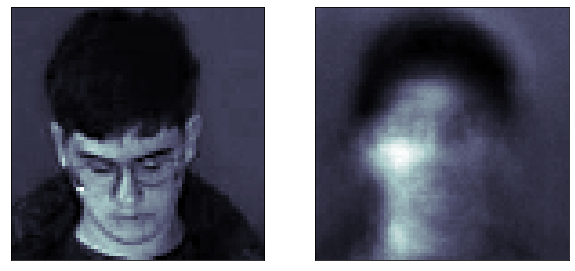

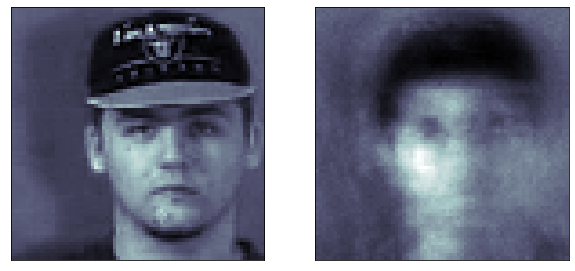

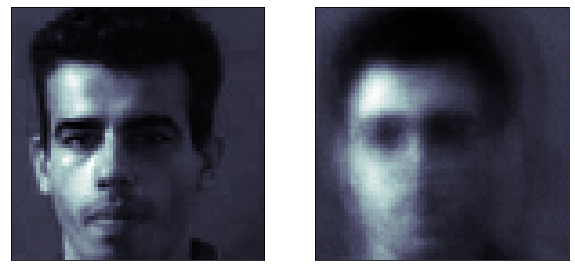

In [63]:
for i in range(10):
  compareinout(i, output_image, X_te)
